# Solving for droplet's geometry due to body force (e.g., gravity)

This code demonstrates how solve for a droplet's geometry using Young-Laplace equation. Instructions on setting up python on your computer can be found in https://swcarpentry.github.io/2013-08-23-harvard/.

Libraries required:
1. numpy
2. matplotlib
3. scipy
4. seaborn

Information about ODE solver in python can be found in 
https://danielmuellerkomorowska.com/2021/02/16/differential-equations-with-scipy-odeint-or-solve_ivp/

## Set up jupyter notebook

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import odeint
from scipy.optimize import newton, fsolve
from scipy.integrate import simps
from scipy.integrate import solve_ivp

# Solving Young-Laplace equation

<img src="Schematic-Young-Laplace-PD.svg" style="width:300px">

Schematic taken from https://www.dataphysics-instruments.com/knowledge/understanding-interfaces/pendant-drop-method/

The droplet geometry is described by the Young-Laplace equation

\begin{align}
\gamma (1/R_{1} + 1/R_{2}) &= \Delta P_{o} - \rho g z  \\
\end{align}

which can be parameterized by the arc length $s$

\begin{align}
\frac{\text{d}\phi}{\text{d}s} &= - \frac{\sin \phi}{x} + \frac{2}{R} - \frac{\rho g z}{\gamma}  \\
\frac{\text{d}x}{\text{d}s} &= \cos \phi \\
\frac{\text{d}z}{\text{d}s} &= \sin \phi \\
\end{align}

where $1/R_{1} = 1/R_{2} = 1/R$ at $z=0$, and with the initial boundary conditions, $x$, $\phi$, $z$ = 0 at $s$=0.

A natural way to non-dimensionalize the problem is to divide the variables by the length-scale $V^{1/3}$, i.e., 

\begin{align}
\hat{x} &=  x V^{-1/3} \\
\hat{s} &=  s V^{-1/3} \\
\hat{R} &=  R V^{-1/3} \\
\hat{V} &= 1 , \, \mathrm{etc}
\end{align}

and we get

\begin{align}
\frac{\text{d}\phi}{\text{d}\hat{s}} &= - \frac{\sin \phi}{\hat{x}} + \frac{2}{\hat{R}} - Bo \, \hat{z} \\
\frac{\text{d}\hat{x}}{\text{d}\hat{s}} &= \cos \phi \\
\frac{\text{d}\hat{z}}{\text{d}\hat{s}} &= \sin \phi 
\end{align}

where $Bo$ = $\rho g V^{2/3}/\gamma$ is the Bond number, for $\hat{s} \in (0, S_{f})$. 

Using the shooting method, we chose to frame the Young-Laplace equation as an initial value problem for, 
with initial boundary conditions, 

$\hat{x}$, $\phi$, $\hat{z}$ = 0 at $\hat{s}$=0

and end boundary condition

$\phi(\hat{S_{f}}) = \theta$

while requiring that

$$ \int_{0}^{\hat{z}(\hat{R}, S_{f})} \pi \hat{x}^{2}d\hat{z} = 1$$.

This converts the boundary value problem into a root-finding problem of $\mathbf{\hat{m} (\hat{R}, S_{f}) }=0$, i.e.,  
$$\mathbf{\hat{m}}(\hat{R}, S_{f}) =
\begin{pmatrix} \phi(S_{f}) - \theta \\ 
\int_{0}^{\hat{z}(S_f)} \pi \hat{u}^{2}d\hat{z} - 1\\
 \end{pmatrix} = 0$$.

with both $R$ and $S_{f}$ are parameters



# Implementation

Simple example of solving Young-Laplace

4.661532374646224
148.94254996275086


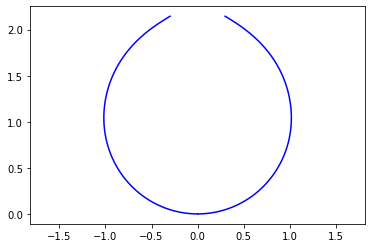

In [31]:
def f(s, v, Bo, R):
    
    phi, x, z = v
    
    f_phi = 2/R - Bo*z - np.sin(phi)/x
    f_x = np.cos(phi)
    f_z = np.sin(phi)
    
    return f_phi, f_x, f_z

def calculate_V(x, z):
    V = simps(np.pi*x**2, z)
    return V

s_start = 0
s_end = 3
n_points = 5000
theta = 5./180*np.pi # contact angle at the top surface

Bo = 0.1
R = 1
sol = solve_ivp(f, (s_start, s_end), (1e-5, 1e-5, 1e-5), 
                          t_eval = np.linspace(s_start, s_end, n_points), args = [Bo, R])

phi, x, z = sol.y

plt.plot(x, z, '-b')
plt.plot(-x, z, '-b')
plt.axis('equal')
plt.xlim([-1.1,1.1])

print (calculate_V(x, z))
print (phi[-1]/np.pi*180)

# Solving Young-Laplace given contact angle on solid and body force

[ 1.43496326e-14 -2.99760217e-15]
[18.63391109  2.3430302 ]
1.0000000002255192
5.0000000000008225


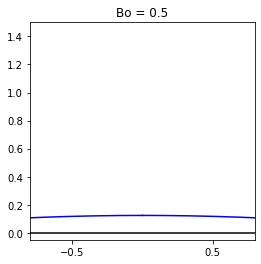

In [32]:
def f(s, v, Bo, R):
    
    phi, x, z = v
    
    f_phi = 2/R - Bo*z - np.sin(phi)/x
    f_x = np.cos(phi)
    f_z = np.sin(phi)
    
    return f_phi, f_x, f_z

def calculate_V(x, z):
    V = simps(np.pi*x**2, z)
    return V

def calculate_Laplace(R, s_end, Bo, n_points=5000): 
    sol = solve_ivp(f, (0, s_end), (1e-5, 1e-5, 1e-5), 
                          t_eval = np.linspace(0, s_end, n_points), args = [Bo, R])
    
    phi, x, z = sol.y
    return [phi, x, z]

def m_res(u, Bo, theta, n_points=5000):
    
    R = u[0]    
    s_end = u[1]
    
    phi, x, z = calculate_Laplace(R, s_end, Bo, n_points)
    return np.array([phi[-1]-theta, calculate_V(x, z)-1])

theta = 5./180*np.pi # contact angle at the top surface
Bo = 0.5

# guess values (non-dimensionalized)
R_guess = 0.6                       
S_f_guess = np.pi/2

u_guess = np.array([R_guess,S_f_guess])

# root-finding solver, look for solution m=0
u_opt = fsolve(m_res, u_guess, args=(Bo, theta, 5000))
print (m_res(u_opt, Bo, theta))
print (u_opt)

R_opt, s_end_opt = u_opt
phi, x, z = calculate_Laplace(R_opt, s_end_opt, Bo, 1000)

print (calculate_V(x, z))
print (phi[-1]/np.pi*180)

fig, ax = plt.subplots()

title = "Bo = {}".format(Bo)
ax.plot(x, -z+z[-1], color='b')
ax.plot(-x, -z+z[-1], color='b')
ax.plot([-1, 1], [0,0], '-k')
ax.set_xlim([-0.8, 0.8])
ax.set_xticks([-0.5, 0.5])
ax.set_ylim([-0.05, 1.5])
ax.set_title(title)

ax.set_aspect('equal')


# Varying the Bo

In [33]:
Bo_arr_1 = np.arange(3, 7, 0.05)
n_files = len(Bo_arr_1)
theta = 30./180*np.pi # contact angle at the top surface

err_arr_1 = np.zeros(n_files)     # Error in simulation
r_arr_1 = np.zeros(n_files)       # contact size
theta_arr_1 = np.zeros(n_files)   # contact angle
h_arr_1 = np.zeros(n_files)       # droplet height
F_arr_1 = np.zeros(n_files)       # Net force acting on the droplet

for i in np.arange(n_files):
    
    if i==0:
        R_guess = 0.6
        S_f_guess = np.pi/2
    
    Bo = Bo_arr_1[i]
    
    
    u_guess = np.array([R_guess,S_f_guess])

    # root-finding solver, look for solution m=0
    u_opt = fsolve(m_res, u_guess, args=(Bo, theta, 5000))
    
    R_opt, s_end_opt = u_opt
    phi, x, z = calculate_Laplace(R_opt, s_end_opt, Bo, 1000)
    
    file_name = "Simulation_10/image{:03d}.png".format(i)
    
    fig, ax = plt.subplots()

    title = "Bo = {:.2f}".format(Bo)
    ax.plot(x, -z+z[-1], color='b')
    ax.plot(-x, -z+z[-1], color='b')
    ax.plot([-2, 2], [0,0], '-k')
    ax.set_xlim([-2, 2])
    ax.set_xticks([-0.5, 0.5])
    ax.set_ylim([-0.05, 1.5])
    ax.set_title(title)

    ax.set_aspect('equal')
    plt.xticks([-2, -1, 0, 1, 2])
    plt.yticks([0, 0.5, 1, 1.5])
    
    fig.savefig(file_name)
    plt.close('all')
    
    # Store simulation data
    r_arr_1[i] = x[-1]
    theta_arr_1[i] = phi[-1]/np.pi*180
    err_arr_1[i] = np.mean(np.abs(m_res(u_opt, Bo, theta)))
    h_arr_1[i] = z[-1]
    
    
    # Force acting on the droplet
    F_capillary = 2*np.pi*x[-1]*np.sin(theta)  # capillary force
    F_laplace = np.pi*x[-1]**2 * (2/R_opt - Bo*z[-1])   # Laplace pressure term 
    W = Bo
    F_net = F_laplace + W - F_capillary
    F_arr_1[i] = F_net
    
    R_guess = u_opt[0]
    S_f_guess = u_opt[1]
    
    

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpac

In [34]:
Bo_arr_2 = np.arange(0, 2, 0.05)
n_files = len(Bo_arr_2)
theta = 130./180*np.pi # contact angle at the top surface

err_arr_2 = np.zeros(n_files)     # Error in simulation
r_arr_2 = np.zeros(n_files)       # contact size
theta_arr_2 = np.zeros(n_files)   # contact angle
h_arr_2 = np.zeros(n_files)       # droplet height
F_arr_2 = np.zeros(n_files)       # Net force acting on the droplet

for i in np.arange(n_files):
    
    if i==0:
        R_guess = 0.6
        S_f_guess = np.pi/2
    
    Bo = Bo_arr_2[i]
    
    
    u_guess = np.array([R_guess,S_f_guess])

    # root-finding solver, look for solution m=0
    u_opt = fsolve(m_res, u_guess, args=(Bo, theta, 5000))
    
    R_opt, s_end_opt = u_opt
    phi, x, z = calculate_Laplace(R_opt, s_end_opt, Bo, 1000)
    
    file_name = "Simulation_130/image{:03d}.png".format(i)
    
    fig, ax = plt.subplots()

    title = "Bo = {:.2f}".format(Bo)
    ax.plot(x, -z+z[-1], color='b')
    ax.plot(-x, -z+z[-1], color='b')
    ax.plot([-2, 2], [0,0], '-k')
    ax.set_xlim([-2, 2])
    ax.set_xticks([-0.5, 0.5])
    ax.set_ylim([-0.05, 1.5])
    ax.set_title(title)

    ax.set_aspect('equal')
    plt.xticks([-2, -1, 0, 1, 2])
    plt.yticks([0, 0.5, 1, 1.5])
    
    fig.savefig(file_name)
    plt.close('all')
    
    # Store simulation data
    r_arr_2[i] = x[-1]
    theta_arr_2[i] = phi[-1]/np.pi*180
    err_arr_2[i] = np.mean(np.abs(m_res(u_opt, Bo, theta)))
    h_arr_2[i] = z[-1]
    
    
    # Force acting on the droplet
    F_capillary = 2*np.pi*x[-1]*np.sin(theta)  # capillary force
    F_laplace = np.pi*x[-1]**2 * (2/R_opt - Bo*z[-1])   # Laplace pressure term 
    W = Bo
    F_net = F_laplace + W - F_capillary
    F_arr_2[i] = F_net
    
    R_guess = u_opt[0]
    S_f_guess = u_opt[1]


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/lib/python3.8/site-packages

# Simulation results

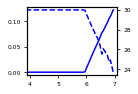

In [54]:
def plot_data(fig, ax):
    ls_1 = 1.0
    ls_2 = 1.0
    ls_3 = 0.8

    ms = 6 # marker size
    fs_1 = 6
    fs_2 = 6
    
    ax.tick_params(axis='x', labelsize=fs_1)
    ax.tick_params(axis='y', labelsize=fs_1)

    scale = 0.7
    fig.set_size_inches(scale*2.1*1.1,scale*1.8)

    ax.xaxis.set_tick_params(length=3)
    ax.yaxis.set_tick_params(length=3)
    
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(1.1)


fig, ax = plt.subplots()
ax_sec = ax.twinx()

ax.plot(Bo_arr_1, err_arr_1, '-b')
ax_sec.plot(Bo_arr_1, theta_arr_1, '--b')

# ax.set_xlabel('F')
# ax.set_ylabel('Numerical error')

ax.set_xlim([3.9, 7.1])
plot_data(fig, ax)
plot_data(fig, ax_sec)

fig.savefig("theta_30.pdf")
# plt.xlim([7, 7.2])

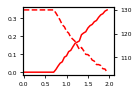

In [55]:
fig, ax = plt.subplots()
ax_sec = ax.twinx()

ax.plot(Bo_arr_2, err_arr_2, '-r')
ax_sec.plot(Bo_arr_2, theta_arr_2, '--r')
ax.set_xlim([-0.01, 2.1])
# ax.set_xlabel('F')
# ax.set_ylabel('Numerical error')

plot_data(fig, ax)
plot_data(fig, ax_sec)
fig.savefig("theta_130.pdf")


Numerical error increases after $Bo$ = 1.4, i.e., there is no solution to Laplace equation beyond critical $Bo$. 

Text(0, 0.5, 'Contact angle')

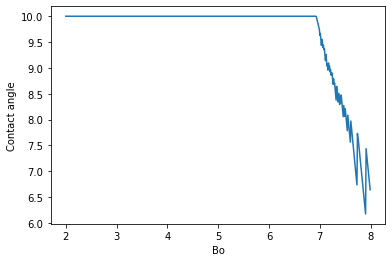

In [6]:
plt.plot(Bo_arr, theta_arr)
plt.xlabel('Bo')
plt.ylabel('Contact angle')

Contact angle deviates from the target $\theta$ = 110$^{\circ}$ beyond critical $Bo$

(1.1, 1.2)

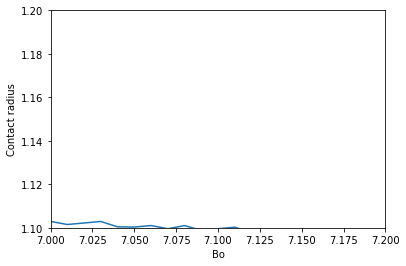

In [7]:
plt.plot(Bo_arr, r_arr)
plt.xlabel('Bo')
plt.ylabel('Contact radius')
plt.xlim([7, 7.2])
plt.ylim([1.1, 1.2])

Contact size increases beyond critical $Bo$, which is unphysical

Text(0, 0.5, 'Force')

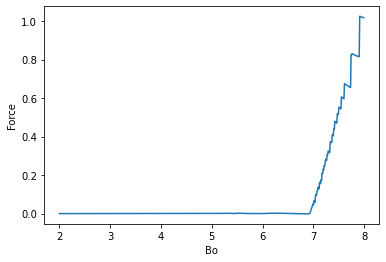

In [8]:
plt.plot(Bo_arr, F_arr)
plt.xlabel('Bo')
plt.ylabel('Force')

Net force is no longer zero beyond critical $Bo$

# Analyze forces at critical Bo

1.098570208429932 0.4682784312262022 0.8153500989422428


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


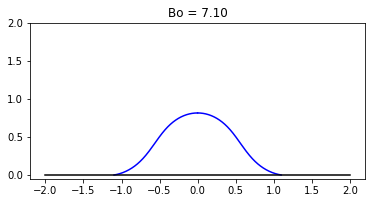

In [9]:
ind = np.argmin(r_arr)
Bo_crit = Bo_arr[ind]
Bo_crit = 7.1

u_guess = np.array([0.47,1])

# root-finding solver, look for solution m=0
u_opt = fsolve(m_res, u_guess, args=(Bo_crit, theta, 5000))
    
R_opt, s_end_opt = u_opt
phi, x, z = calculate_Laplace(R_opt, s_end_opt, Bo_crit, 1000)
    
    
fig, ax = plt.subplots()

title = "Bo = {:.2f}".format(Bo_crit)
ax.plot(x, -z+z[-1], color='b')
ax.plot(-x, -z+z[-1], color='b')
ax.plot([-2, 2], [0,0], '-k')
# ax.set_xlim([-0.8, 0.8])
ax.set_ylim([-0.05, 2])

# ax.set_xticks([])
# ax.set_yticks([])
ax.set_title(title)

ax.set_aspect('equal')

r_crit = x[-1]
R_crit = R_opt
h_crit = z[-1]
print (r_crit, R_crit, h_crit)


In [10]:
F_capillary = 2*np.pi*r_crit*np.sin(theta)  # capillary force
F_laplace = np.pi*r_crit**2 * (2/R_crit - Bo_crit*h_crit)   # Laplace pressure term 
W = Bo_crit

print (F_capillary, F_laplace, W)
print (F_laplace + W - F_capillary)

1.1986100527389265 -5.755508301313756 7.1
0.14588164594731712


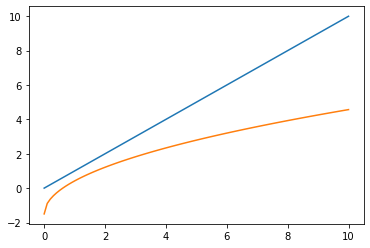

In [11]:
x = np.linspace(0, 10, 100)

y = (np.sqrt(x) - (3/(2*np.pi))**(1/3))*np.pi*(3/(2*np.pi))**(2/3)

plt.plot(x, x)
plt.plot(x, y)